In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
np.random.seed(0)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
class adversial_env(object):
    def __init__(self,runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        self.mask = np.random.choice([1],size = [1,15])
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(3*self.env.observation_space.shape[0],))
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = a
        self.obsr, r, done, _ = self.env.step(ac)
        self.obsr = np.concatenate((self.obsr, self.obsr+0.1, self.obsr-0.1), axis=0)
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        if self.epi_num%300 == 299:
            self.mask = np.random.choice([1],size = [1,15])
            self.mask[0,np.random.randint(0,14, size=1)[0]] = 0 
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*self.mask)[0]
            
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = a
        self.obsr, r, done, _ = self.env.step(ac)
        self.obsr = np.concatenate((self.obsr, self.obsr+0.1, self.obsr-0.1), axis=0)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.mask = np.random.choice([1],size = [1,15])
        self.obsr = self.env.reset()
        self.obsr = np.concatenate((self.obsr, self.obsr+0.1, self.obsr-0.1), axis=0)
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        x = list(range(0, len(self.score_list[1:])))
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.scatter(x,self.score_list[1:], s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        plt.ylim([0,1200])
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        x = list(range(0, len(self.epi_list)))
        plt.scatter(x,self.epi_list, s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.ylim([0,1200])
        plt.show()

Every 300 step change a sensor to mask

# define an observer (new agent) and save running state

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 100000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)


[2018-04-14 18:51:13,750] Making new env: RoboschoolInvertedPendulum-v1


In [4]:
agn.learn()

44.0 [44.0] [45]
Episode 0	Last reward: 26.0	Average reward 23.49
('lagrange multiplier:', 1.0478159177801525, 'grad_norm:', 0.17174324118335013)
fval before 1.4235754521874443e-14
a/e/r 0.02087469740095478 0.020956318355614508 0.996105186355987
fval after -0.020874697400940546
Episode 1	Last reward: 26.0	Average reward 30.72
('lagrange multiplier:', 1.6383706342378368, 'grad_norm:', 0.26072298996113263)
fval before -3.3229172502780365e-15
a/e/r 0.036208292360332815 0.03276741268424002 1.1050091964614508
fval after -0.03620829236033614
Episode 2	Last reward: 63.0	Average reward 46.49
('lagrange multiplier:', 1.6531763652716045, 'grad_norm:', 0.2894778756051996)
fval before 4.290541364047409e-15
a/e/r 0.035869980846579635 0.03306352730479944 1.0848806455496602
fval after -0.03586998084657535
Episode 3	Last reward: 132.0	Average reward 88.81
('lagrange multiplier:', 1.5218924397485856, 'grad_norm:', 0.2733333441626406)
fval before -5.469251015147123e-15
a/e/r 0.03148269536290553 0.030437

[2018-04-14 19:00:53,882] Making new env: RoboschoolInvertedPendulum-v1


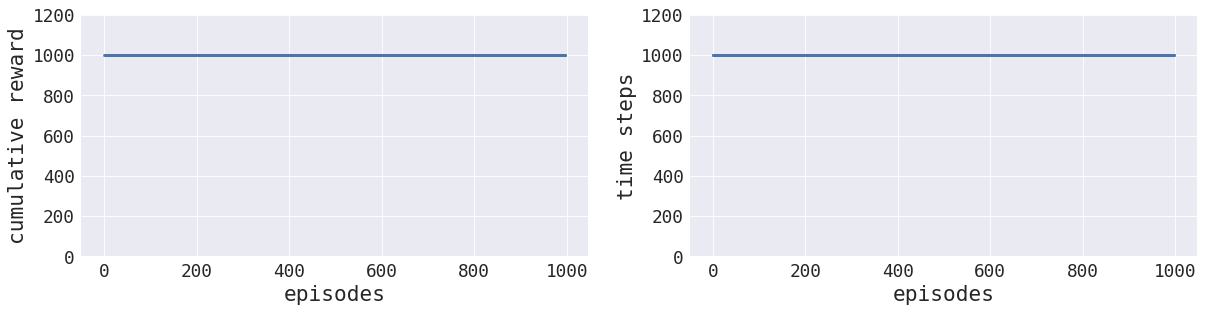

In [5]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

env.result_plot()

In [6]:
agn.save_model('agent_model/random_period_mask_observer_triple_sensor')

# Without adversarial training 

In [7]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-04-14 19:07:36,074] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


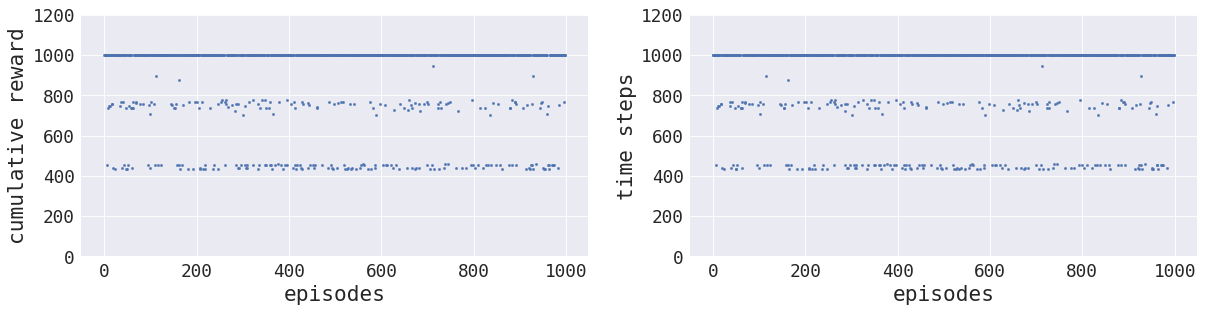

In [8]:
env.result_plot()

In [9]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 100000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_period_mask_observer_triple_sensor')

[2018-04-14 19:13:41,388] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [10]:
agn.learn(run_state_update = False) # disable running state update

451.0 [451.0] [452]
Episode 0	Last reward: 706.0	Average reward 823.70
('lagrange multiplier:', 0.5094575721670208, 'grad_norm:', 0.08358616987169197)
fval before -7.230298308811839e-17
a/e/r 0.010120084768106816 0.010189151511422691 0.9932215412403627
fval after -0.010120084768106889
Episode 1	Last reward: 1000.0	Average reward 915.27
('lagrange multiplier:', 0.18879560144329555, 'grad_norm:', 0.02452796771867967)
fval before 4.6561439205177405e-16
a/e/r 0.0037027593109130886 0.003775912107459355 0.98062645674359
fval after -0.003702759310912623
Episode 2	Last reward: 1000.0	Average reward 968.24
('lagrange multiplier:', 0.15898433086530206, 'grad_norm:', 0.03822546173968283)
fval before -1.8579975978413595e-16
a/e/r 0.00321481246010702 0.0031796866111835297 1.0110469531179413
fval after -0.0032148124601072054
Episode 3	Last reward: 1000.0	Average reward 1000.00


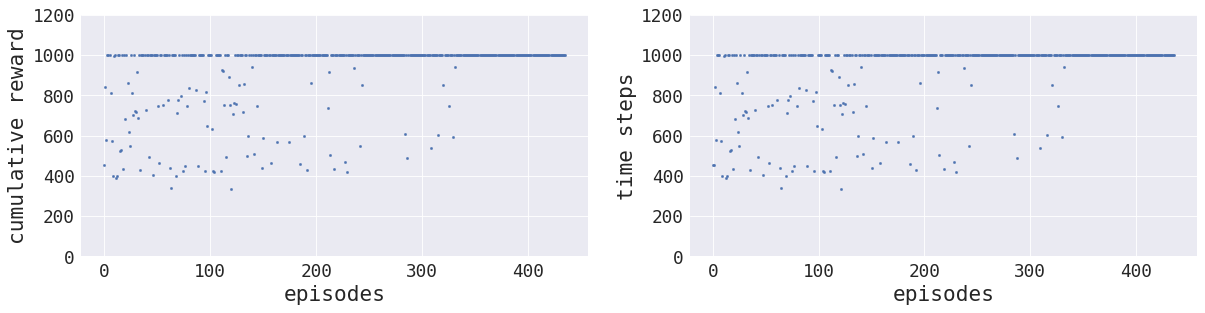

In [11]:
env.result_plot()

# Agent evaluation

In [12]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-04-14 19:18:11,557] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


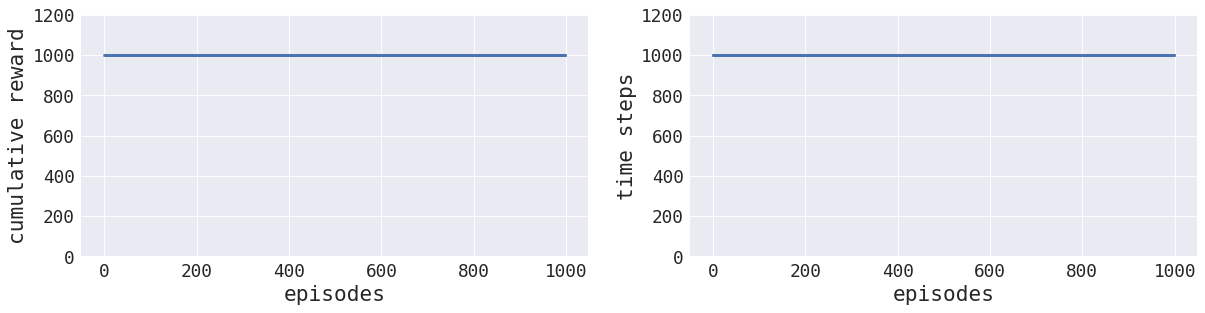

In [13]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [14]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-04-14 19:25:40,203] Making new env: RoboschoolInvertedPendulum-v1


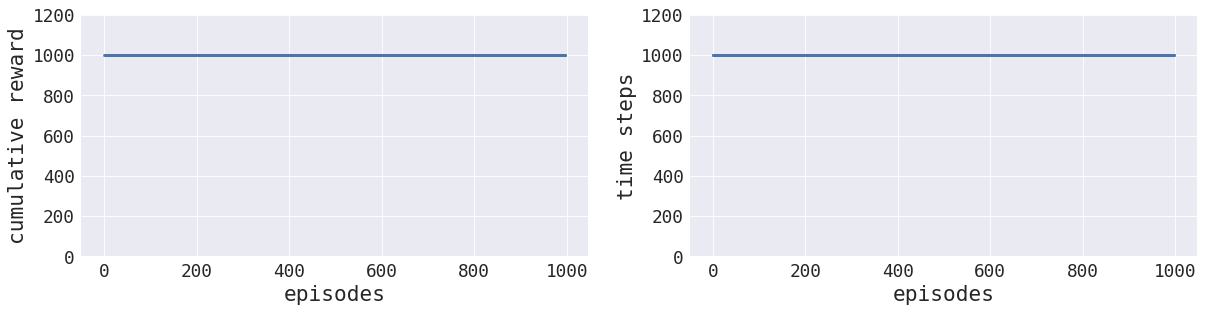

In [15]:
env.result_plot()

# Save model

In [16]:
agn.save_model('agent_model/random_period_mask_observer_triple_sensor')